In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F

from diffusers.schedulers.scheduling_ddpm import DDPMScheduler

from dit_core import DiffusionTransformer, EMA, _extract_into_tensor

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
rb_pos_world = np.zeros((8,8,2))
kdtree_positions_world = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
        else:
            finger_pos = np.array((i*0.0375, j*0.043301))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301))
        kdtree_positions_world[i*8 + j, :] = rb_pos_world[i,j]

In [3]:
def get_strings_by_indices(strings_list, indices_array):
    result = []
    for index in indices_array:
        result.append(strings_list[index])
    return result

replay_buffer = pkl.load(open('../../data/replay_buffer.pkl', 'rb'))

rewards = replay_buffer['rew']
idxs = np.where(rewards>-5)[0]

states = replay_buffer['obs'][idxs]
actions = replay_buffer['act'][idxs]
pos = replay_buffer['pos'][idxs]
obj_names = get_strings_by_indices(replay_buffer['obj_names'], idxs)
num_agents = replay_buffer['num_agents'][idxs]

In [4]:
obj_name_enc_dim = len(np.unique(replay_buffer['obj_names']))

In [5]:
class ImitationDataset(Dataset):
    def __init__(self, states, actions, pos, num_agents, obj_names):
        self.states = states
        self.actions = actions
        self.pos = pos
        self.num_agents = num_agents
        names = ['block', 'disc', 'hexagon', 'parallelogram', 'semicircle', 'shuriken', 'star', 'trapezium', 'triangle']
        # encoder = OneHotEncoder(sparse=False)
        encoder = LabelEncoder()
        # self.obj_names_encoded = encoder.fit_transform(np.array(obj_names).reshape(-1, 1))
        self.obj_names_encoded = encoder.fit_transform(np.array(obj_names).reshape(-1, 1))


    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        state = self.states[idx]
        action = self.actions[idx]
        obj_names_encoded = self.obj_names_encoded[idx]
        pos = self.pos[idx]
        num_agents = self.num_agents[idx]
        return state, action, obj_names_encoded, pos, num_agents

dataset = ImitationDataset(states, actions, pos, num_agents, obj_names)

train_size = 0.7
val_size = 0.15
test_size = 0.15
train_indices, temp_indices = train_test_split(list(range(len(dataset))), test_size=(val_size + test_size), random_state=69420)
val_indices, test_indices = train_test_split(temp_indices, test_size=(test_size / (test_size + val_size)), random_state=69420)

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

/home/sarvesh/anaconda3/envs/py310/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [6]:
hp_dict = {
        "exp_name"          : "MADP_0",
        "data_dir"          : "./data/rl_data",
        'lr'                : 1e-5,
        'epochs'            : 100,

        # DiT Params:
        'state_dim'         : 6,
        'obj_name_enc_dim'  : obj_name_enc_dim,
        'action_dim'        : 2,
        "device"            : torch.device(f"cuda:0"),
        "model_dim"         : 128,
        "num_heads"         : 8,
        "dim_ff"            : 64,
        "n_layers_dict"     : {'denoising_decoder': 8},
        "dropout"           : 0,
        "max_grad_norm"     : 1.0,

        "Denoising Params"  :{
            'num_train_timesteps'   : 100,
            'beta_start'        : 0.0001,
            'beta_end'          : 0.02,
            'beta_schedule'     : 'squaredcos_cap_v2',
            'variance_type'     : 'fixed_small_log',
            'clip_sample'       : True ,
            'prediction_type'   : 'epsilon',
        },

        "EMA Params":{
            'update_after_step' : 0,
            'inv_gamma'         : 1.0,
            'power'             : 0.75,
            'min_value'         : 0.5,
            'max_value'         : 0.9999,
        }
    }
# Implementation TODOs:
#   1. Add KL Divergence loss
#   2. Add normalization
#   3. Add CAWR

model = DiffusionTransformer(hp_dict['state_dim'], hp_dict['action_dim'], hp_dict['obj_name_enc_dim'], hp_dict['Denoising Params'], hp_dict['model_dim'], hp_dict['num_heads'], hp_dict['dim_ff'], hp_dict['n_layers_dict'], hp_dict['dropout'], hp_dict['device'], './idx_embedding.pth')
ema_model = deepcopy(model).to(hp_dict['device'])
model.to(hp_dict['device'])
optimizer = optim.AdamW(model.parameters(), lr=hp_dict['lr'], weight_decay=0)

ema = EMA(ema_model, **hp_dict['EMA Params'])

Training Epoch 0:   0%|          | 0/2731 [00:00<?, ?it/s]

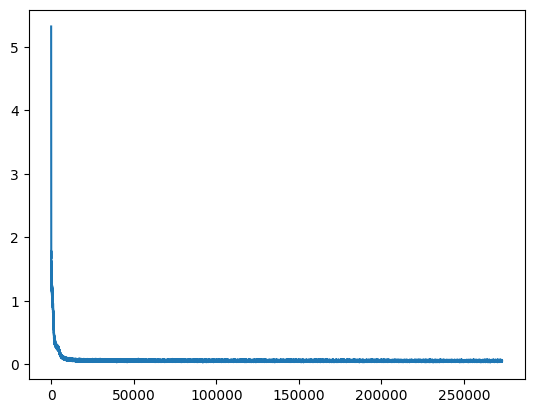

In [7]:
losses = []
for epoch in range(hp_dict['epochs']):
    with tqdm.tqdm(train_loader, desc=f"Training Epoch {epoch}", leave=False, mininterval=1) as t:
        for i, (states, actions, obj_name_encs, pos, num_agents) in enumerate(t):
            n_agents = int(torch.max(num_agents))
            
            # Noised and Denoised Variable
            actions = actions[:, :n_agents].to(hp_dict['device'])

            # Conditioning Variables
            states = states[:, :n_agents].to(hp_dict['device'])
            obj_name_encs = obj_name_encs.long().to(hp_dict['device'])
            pos = pos[:, :n_agents].to(hp_dict['device'])

            optimizer.zero_grad()
            loss = model.compute_loss(actions, states, obj_name_encs, pos)
            loss.backward()
            optimizer.step()
            ema.step(model)

            losses.append(loss.item())
            t.set_postfix(loss=np.mean(losses[-300:]), refresh=False)
        
        ema_model.eval()        

In [10]:
expt_dict = {"model": model.state_dict(), "ema_model": ema_model.state_dict(), "optimizer": optimizer.state_dict()}
torch.save(expt_dict, 'madp_expt_0.pth')

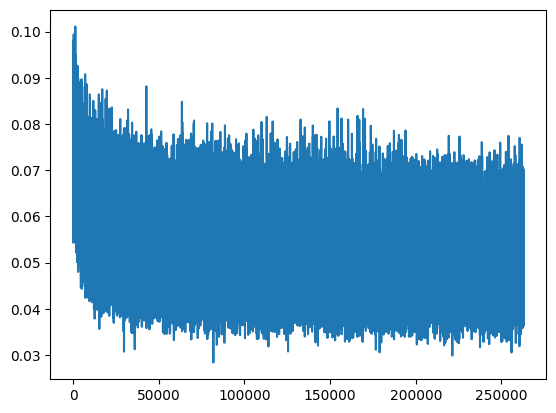

In [8]:
plt.plot(losses[10000:])

In [9]:

def actions_from_denoising_diffusion(model, x_T, states, obj_name_encs, pos, gamma=None):
    # actions get denoised from x_T --> x_t --> x_0
    actions = x_T
    shape = actions.shape
    with torch.no_grad():
        for i in reversed(range(model.denoising_params['num_train_timesteps'])):
            t = torch.tensor([i]*shape[0], device=model.device)
            ### p_mean_variance
            pred_noise = model.denoising_decoder(actions, states, obj_name_encs, pos)

            model_variance = _extract_into_tensor(model.posterior_variance, t, shape)
            model_log_variance = _extract_into_tensor(model.posterior_log_variance_clipped, t, shape)

            pred_x_start = _extract_into_tensor(model.sqrt_recip_alphas_cumprod, t, shape) * actions\
                        - _extract_into_tensor(model.sqrt_recipm1_alphas_cumprod, t, shape) * pred_noise
            
            model_mean = _extract_into_tensor(model.posterior_mean_coef1, t, shape) * pred_x_start\
                        + _extract_into_tensor(model.posterior_mean_coef2, t, shape) * actions
            
            ### p_sample
            noise = torch.randn(shape, device=model.device)
            nonzero_mask = ((t != 0).float().view(-1, *([1] * (len(shape) - 1))))
            actions = model_mean + nonzero_mask * torch.exp(0.5*model_log_variance) * noise
    return actions

In [25]:
model.eval()
loss = []
statesss = []
actionsss = []
actions_gt = []
possss = []
with torch.no_grad():
    with tqdm.tqdm(val_loader, desc=f"Training Epoch {epoch}", leave=False, mininterval=1) as v:
        for i, (states, actions, obj_name_encs, pos, num_agents) in enumerate(v):
            n_agents = int(torch.max(num_agents))
            
            # Noised and Denoised Variable
            actions = actions[:, :n_agents].to(hp_dict['device'])
            actions_gt.append(actions)

            # Conditioning Variables
            states = states[:, :n_agents].to(hp_dict['device'])
            statesss.append(states)
            obj_name_encs = obj_name_encs.to(hp_dict['device'])
            pos = pos[:, :n_agents].to(hp_dict['device'])
            possss.append(pos)

            noise = torch.randn(actions.shape, device=hp_dict['device'])
            denoised_actions = actions_from_denoising_diffusion(model, noise, states, obj_name_encs, pos)
            actionsss.append(denoised_actions)
            loss.append(F.mse_loss(actions, denoised_actions).item())

            if i==100:
                break

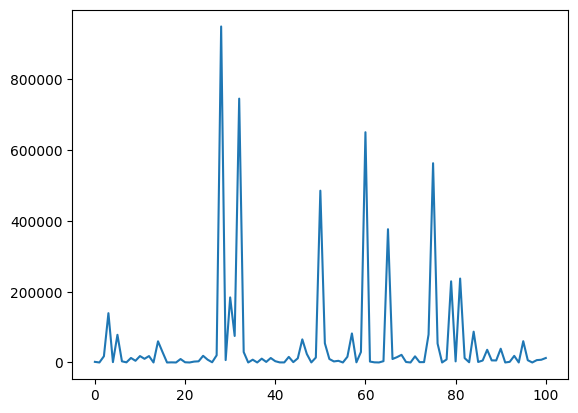

In [26]:
plt.plot(loss)

In [ ]:
statesss[0].detach().cpu().numpy().shape, len(statesss)

((1, 5, 6), 101)

[[-0.00619563 -0.00292163 -0.02110477 -0.03327753 -0.00477831 -0.00258124]
 [ 0.0083111   0.00902386 -0.01383318  0.00257587  0.00515247  0.00951429]
 [-0.01269432  0.0106558  -0.03787872 -0.01536073 -0.01002341  0.01094363]
 [ 0.01522809 -0.02657231  0.0110008  -0.0389405   0.00968044 -0.02004385]
 [-0.00107297  0.01888994 -0.0293533   0.00310121 -0.00040547  0.01707319]] [[ 0.79735744 -0.6035074 ]
 [-0.74116236 -0.67132574]
 [-0.5211499   0.8534652 ]
 [-0.529799   -0.84812325]
 [ 0.28903693 -0.9573179 ]]


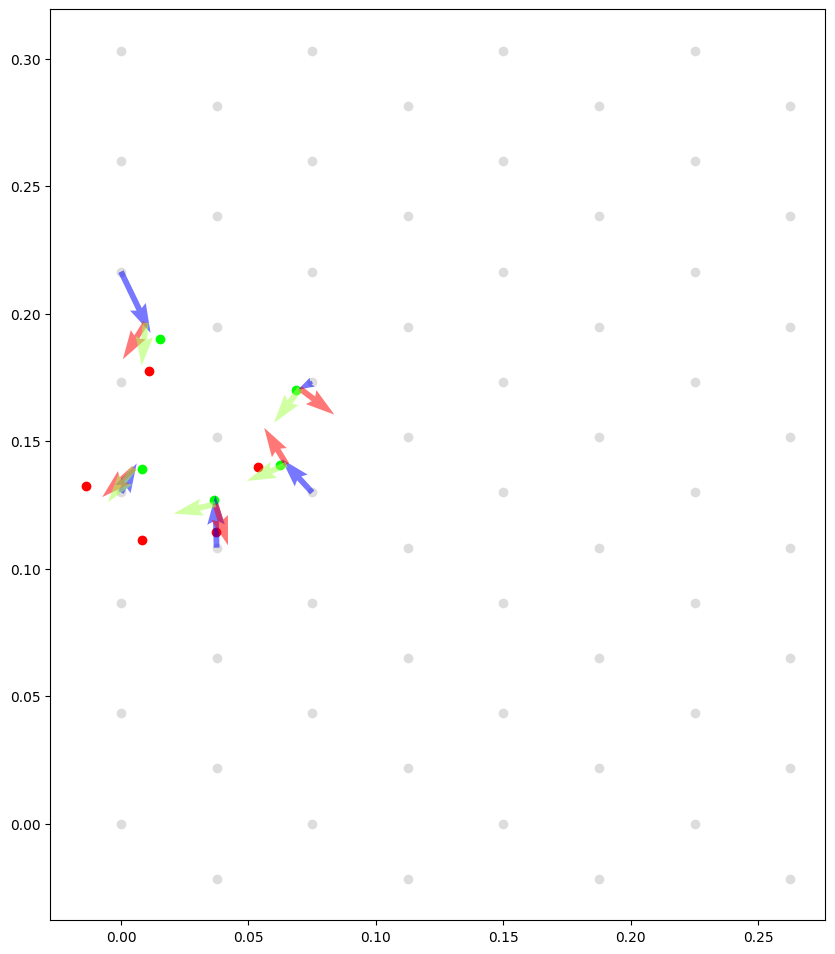

In [30]:
plt.figure(figsize=(10,17.78))
for n, (state, action, action_gt, pos) in enumerate(zip(statesss, actionsss, actions_gt, possss)):
    if n==67:
        state, action, action_gt, pos = state[0], action[0], action_gt[0], pos[0]
        pos = pos.squeeze().detach().cpu().numpy()
        r_poses = kdtree_positions_world[pos]
        state = state.squeeze().detach().cpu().numpy()
        init_pts = state[:,:2] + r_poses
        goal_bd_pts = state[:,2:4] + r_poses
        act_grsp = state[:,4:6]
        r_poses2 = r_poses + act_grsp
        acts = action.squeeze().detach().cpu().numpy()
        acts = acts/np.linalg.norm(acts, axis=1).reshape(-1, 1)
        act_gt = action_gt.squeeze().detach().cpu().numpy()
        act_gt = act_gt/np.linalg.norm(act_gt, axis=1).reshape(-1, 1)
        print(state, acts)

        plt.scatter(kdtree_positions_world[:, 0], kdtree_positions_world[:, 1], c='#ddddddff')
        plt.scatter(init_pts[:, 0], init_pts[:, 1], c = '#00ff00ff')
        plt.scatter(goal_bd_pts[:, 0], goal_bd_pts[:, 1], c='red')

        plt.quiver(r_poses[:, 0], r_poses[:, 1], act_grsp[:, 0], act_grsp[:, 1], color='#0000ff88')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], acts[:, 0], acts[:, 1], color='#ff000088')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], act_gt[:, 0], act_gt[:, 1], color='#aaff5588')
        break

plt.gca().set_aspect('equal')
plt.show()

Epoch 1, Loss: 0.0625
Epoch 2, Loss: 0.03125
Epoch 3, Loss: 0.03125
Epoch 4, Loss: 0.0
Epoch 5, Loss: 0.078125
Epoch 6, Loss: 0.046875
Epoch 7, Loss: 0.0
Epoch 8, Loss: 0.015625
Epoch 9, Loss: 0.046875
Epoch 10, Loss: 0.0
Epoch 11, Loss: 0.015625
Epoch 12, Loss: 0.015625
Epoch 13, Loss: 0.0
Epoch 14, Loss: 0.0
Epoch 15, Loss: 0.03125
Epoch 16, Loss: 0.03125
Epoch 17, Loss: 0.0
Epoch 18, Loss: 0.015625
Epoch 19, Loss: 0.0
Epoch 20, Loss: 0.0
Epoch 21, Loss: 0.0
Epoch 22, Loss: 0.015625
Epoch 23, Loss: 0.0
Epoch 24, Loss: 0.03125
Epoch 25, Loss: 0.03125
Epoch 26, Loss: 0.0
Epoch 27, Loss: 0.015625
Epoch 28, Loss: 0.0
Epoch 29, Loss: 0.015625
Epoch 30, Loss: 0.0
Epoch 31, Loss: 0.03125
Epoch 32, Loss: 0.015625
Epoch 33, Loss: 0.0
Epoch 34, Loss: 0.0
Epoch 35, Loss: 0.015625
Epoch 36, Loss: 0.046875
Epoch 37, Loss: 0.0
Epoch 38, Loss: 0.015625
Epoch 39, Loss: 0.03125
Epoch 40, Loss: 0.03125
Epoch 41, Loss: 0.0
Epoch 42, Loss: 0.0
Epoch 43, Loss: 0.015625
Epoch 44, Loss: 0.015625
Epoch 45, 

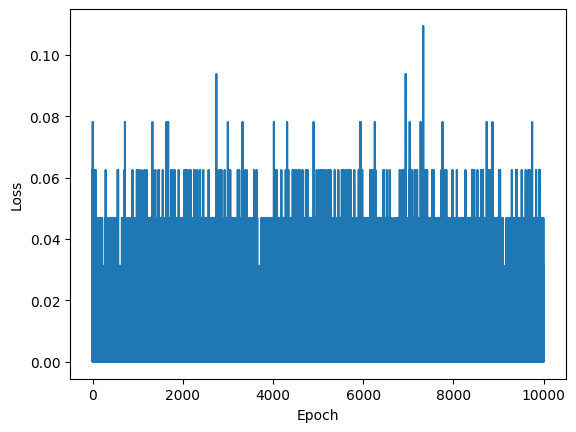

In [ ]:
# BYOL for learning robot idx embeddings
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class IntegerEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(IntegerEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# Model parameters
num_embeddings = 64  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = IntegerEmbeddingModel(num_embeddings, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate a batch of integer indices
    # In a real scenario, you might want to sample these more carefully
    indices = torch.randint(0, num_embeddings, (batch_size,))  # Batch size of 32

    # "View 1" is just the embedding
    embedding1 = model(indices)

    # "View 2" could be the embedding of the next integer, simulating a simple 'transformation'
    # This is a simplistic approach; consider more sophisticated methods for your task
    indices_2 = (indices + torch.randint(0, num_embeddings, (batch_size,))) % num_embeddings  # Ensure it wraps around at the max integer
    embedding2 = model(indices_2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

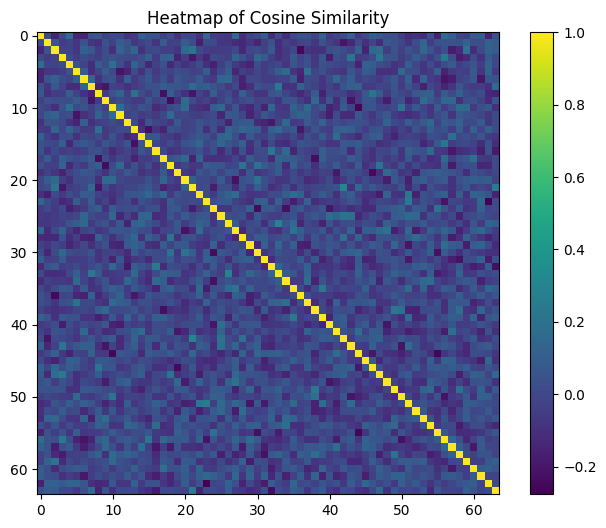

In [ ]:
n_values = torch.arange(64)
a = model(n_values)
b = model(n_values)
cos_sim = torch.nn.CosineSimilarity(dim=0)

cos_sim_matrix = torch.zeros(64, 64)

for i in range(64):
    for j in range(64):
        cos_sim_matrix[i, j] = cos_sim(a[i], b[j])


# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.title("Heatmap of Cosine Similarity")
plt.imshow(cos_sim_matrix.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
a = torch.randint(0, 64, (32,10))
op = model(a)
op.shape

torch.Size([32, 10, 128])

In [ ]:
class ShapeEmbeddingModel(nn.Module):
    def __init__(self, num_bd_pts, hidden_dim, embed_dim):
        super(ShapeEmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer2 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer3 = nn.Linear(num_bd_pts, embed_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# def triplet_loss(anchor, positive, negative, margin=1.0):
#     distance_positive = torch.nn.functional.pairwise_distance(anchor, positive, keepdim=True)
#     distance_negative = torch.nn.functional.pairwise_distance(anchor, negative, keepdim=True)
#     losses = torch.relu(distance_positive - distance_negative + margin)
#     return losses.mean()


bd_pts_dict = pkl.load(open('../../config/assets/obj_props.pkl', 'rb'))
bd_pts = []
for name in bd_pts_dict.keys():
    bd_pts.append(bd_pts_dict[name][1].reshape(512,))

bd_pts = torch.tensor(bd_pts).float()

In [ ]:
# Model parameters
num_objects = 9
num_bd_pts = 256*2  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = ShapeEmbeddingModel(num_bd_pts, 512, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    indices = torch.randint(0, num_objects, (batch_size,))
    input1 = torch.index_select(data, 0, indices)
    embedding1 = model(input1)

    indices_2 = (indices + torch.randint(0, num_objects, (batch_size,))) % num_objects  # Ensure it wraps around at the max integer
    input2 = torch.index_select(data, 0, indices_2)
    embedding2 = model(input2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


TypeError: index_select() received an invalid combination of arguments - got (module, int, Tensor), but expected one of:
 * (Tensor input, int dim, Tensor index, *, Tensor out)
 * (Tensor input, name dim, Tensor index, *, Tensor out)
